In [22]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
import os
import gc
from tqdm import tqdm
from glob import glob
import time
import scipy
from functools import partial
from scipy import signal
from scipy.ndimage import gaussian_filter1d

import torch.jit as jit
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.models import get_model
import timm

import openvino as ov
import openvino.properties as props
import openvino.properties.hint as hints
from concurrent import futures

from src.data_utils import get_metadata, get_fold, get_metadata_from_csv, get_full_data
from src.utils import score_np, roc_auc, score

In [76]:
class Config:
    use_1_peak = False
    peak_filter = 'gaussian'
    use_peaks = True
    n_peaks = 3
    duration = 5
    sample_rate = 32000
    target_length = 500 #!!!!!!!!!!!!
    n_mels = 128 #!!!!!!!!!!!!!!!
    n_fft = 1024
    window = 160 #!!!!!!!!!!!!!
    audio_len = duration*sample_rate
    hop_length = 64 #!!!!!!!!!!
    fmin = 50
    fmax = 16000
    top_db = 80

    n_classes = 182
    n_channels = 1 #!!!!!!!!!!!
    
    use_openvino = True
    multithreading = False
    checkpoint_dir = 'checkpoints/06-07_13-17_128x500_mn20_as_exp-gemsed_peaks_gaussian_mixup'
    loss = 'crossentropy'
    ensemble_checkpoints = ['/kaggle/input/mn-20-peak-full/other/06-07_13-17_128x500_mn20_as_exp-gemsed_peaks_gaussian_mixup/1',
                            '/kaggle/input/mn-20-peak-full/other/06-07_17-36_128x500_mn20_as_exp-gemsed_peaks_gaussian_mixup_nocw/1',
                            '/kaggle/input/mn-20-peak-full/other/06-06_14-28_128x500_mn20_as_exp-peakgemsed_gaussian_mixup/1',
                            #'/kaggle/input/mn-20/other/2024-06-03_01-53-27_gemsed_2wayfocal/1',
                            #'/kaggle/input/mn-20/other/2024-06-03_03-22-49_msgemsed/1',
                            #'/kaggle/input/mn-20/other/2024-05-30_21-30-20_gemattms-128x384/1'
                            #'/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            #'/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            #'/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            #'/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1',
                            #'/kaggle/input/mn-20/other/2024-05-29_10-17-54_att-128-384/1'
                           ]
    ensemble_losses = ['crossentropy', 'crossentropy', 'crossentropy', 'bce', 'crossentropy',
                       'crossentropy', 'crossentropy', 'crossentropy', 'crossentropy', 'crossentropy']

    standardize = False
    dataset_mean = [-22.9137] #[-16.8828]
    dataset_std = [11.8739] #[12.4019]

In [77]:
def create_frames(waveform, duration=5, sr=32000):
    frame_size = int(duration * sr)
    surplus = waveform.size(-1)%frame_size
    if waveform.size(-1) <= surplus:
        waveform = nn.functional.pad(waveform, pad=(0, frame_size - waveform.size(-1)%frame_size), mode='constant', value=0)
    elif surplus > 0:
        waveform = waveform[:, :-surplus]
    frames = waveform.view(-1, 1, frame_size)
    return frames


def find_peak_max(x, filter='savgol'):
    if filter == 'savgol':
        smooth_x = signal.savgol_filter(x, window_length=100, polyorder=2)
    elif filter == 'gaussian':
        smooth_x = gaussian_filter1d(x, sigma=25)
    else:
        smooth_x = x
    return smooth_x.argmax(axis=-1)

def window_around_peak(len_x, peak, window_size):
    half_window = window_size // 2
    start_index = max(0, peak - half_window)
    end_index = min(len_x, peak + half_window)

    # Adjust the window if it's too close to the borders
    if end_index - start_index < window_size:
        if start_index == 0:
            end_index = min(len_x, start_index + window_size)
        elif end_index == len_x:
            start_index = max(0, end_index - window_size)
    return start_index, end_index

def find_peaks_max_inference(x, filter, window, n_peaks):
    if filter == 'savgol':
        smooth_x = signal.savgol_filter(x, window_length=100, polyorder=2)
    elif filter == 'gaussian':
        smooth_x = gaussian_filter1d(x, sigma=25)
    else:
        smooth_x = x

    peaks = []
    for p in range(n_peaks):    
        peak = smooth_x.argmax(axis=-1)
        for k in range(len(peak)):
            s1, s2 = window_around_peak(len(smooth_x[k]), peak[k], window)
            smooth_x[k, s1:s2] = 0
        peaks.append(peak)
    return peaks

class AudioDatasetInference(Dataset):
    def __init__(
            self, 
            files,
            cfg,
            targets = None
            ):
        super(AudioDatasetInference, self).__init__()
        self.files = files
        self.targets = targets
        self.n_classes = cfg.n_classes
        self.duration = cfg.duration
        self.sample_rate = cfg.sample_rate
        self.audio_len = self.duration*self.sample_rate
        self.target_length = cfg.target_length
        self.n_mels = cfg.n_mels
        self.n_fft = cfg.n_fft
        self.window = cfg.window
        self.hop_length = cfg.hop_length
        self.fmin = cfg.fmin
        self.fmax = cfg.fmax
        self.top_db = cfg.top_db
        self.standardize = cfg.standardize
        self.mean = cfg.dataset_mean
        self.std = cfg.dataset_std
        self.n_channels = cfg.n_channels
        self.use_1_peak = cfg.use_1_peak
        self.use_peaks = cfg.use_peaks
        self.peak_filter = cfg.peak_filter
        self.n_peaks = cfg.n_peaks

        self.to_mel_spectrogramn = torchaudio.transforms.MelSpectrogram(self.sample_rate, n_fft=self.n_fft, win_length=self.window,  
                                                 hop_length=self.hop_length, n_mels=self.n_mels, 
                                                 f_min=self.fmin, f_max=self.fmax)

        self.mel_to_db = nn.Sequential(torchaudio.transforms.AmplitudeToDB(top_db=self.top_db))

        if self.mean is not None and self.std is not None:
            self.mel_to_db.append(v2.Normalize(mean=self.mean, std=self.std))

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        if self.targets is not None:
            label = torch.tensor(self.targets[idx])

        file = self.files[idx]
        waveform, sr = torchaudio.load(file)
        frames = create_frames(waveform)[:10]
        spec = self.to_mel_spectrogramn(frames)

        if self.use_1_peak:
            per_frame_energy = spec.sum(dim=-2).squeeze().numpy()
            peaks = find_peak_max(per_frame_energy, filter=self.peak_filter)
            new_spec = torch.empty((spec.size(0), self.n_channels, self.n_mels, self.target_length))
            for p in range(len(peaks)):
                start_index, end_index = window_around_peak(per_frame_energy.shape[-1], peaks[p], self.target_length)
                new_spec[p] = spec[p,:,:,start_index:end_index]
        
        elif self.use_peaks:
            per_frame_energy = spec.sum(dim=-2).squeeze(1).numpy()
            peaks = find_peaks_max_inference(per_frame_energy, filter=self.peak_filter, 
                                   window=self.target_length, n_peaks=self.n_peaks)
            new_spec = torch.empty((spec.size(0)*self.n_peaks, self.n_channels, self.n_mels, self.target_length))
            for k in range(self.n_peaks):
                for p in range(len(peaks[k])):
                    start_index, end_index = window_around_peak(per_frame_energy.shape[-1], peaks[k][p], self.target_length)
                    new_spec[self.n_peaks*p + k%self.n_peaks] = spec[p,:,:,start_index:end_index]

        spec = self.mel_to_db(new_spec)

        # Standardize
        if self.standardize:
            spec = (spec - spec.mean()) / spec.std()

        # expand to 3 channels for imagenet trained models
        if self.n_channels > 1:
            if self.use_peaks:
                spec = spec.expand(-1,self.n_channels,-1,-1)
            else:
                spec = spec.expand(self.n_channels,-1,-1)

        if self.targets is not None:
            return spec, label
        else:
            return spec, file

In [78]:
base_dir = 'data'
train_dir = base_dir + '/train_audio/'
test_dir = base_dir + '/test_soundscapes/'
unlabeled_dir = base_dir + '/unlabeled_soundscapes/'

class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)
class_labels = list(range(n_classes))
label2name = dict(zip(class_labels, class_names))
name2label = {v:k for k,v in label2name.items()}

metadata = get_metadata(10, 'data')

/home/cedric/miniconda3/envs/birds/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


In [79]:
fold = 0
train_df, valid_df, class_weights = get_fold(metadata, fold)
files = valid_df['filepath']
targets = valid_df['target']

Num Train: 22022, 182 classes | Num Valid: 2437, 170 classes


In [80]:
test_dataset = AudioDatasetInference(
    files, 
    targets=None, 
    cfg=Config
    )

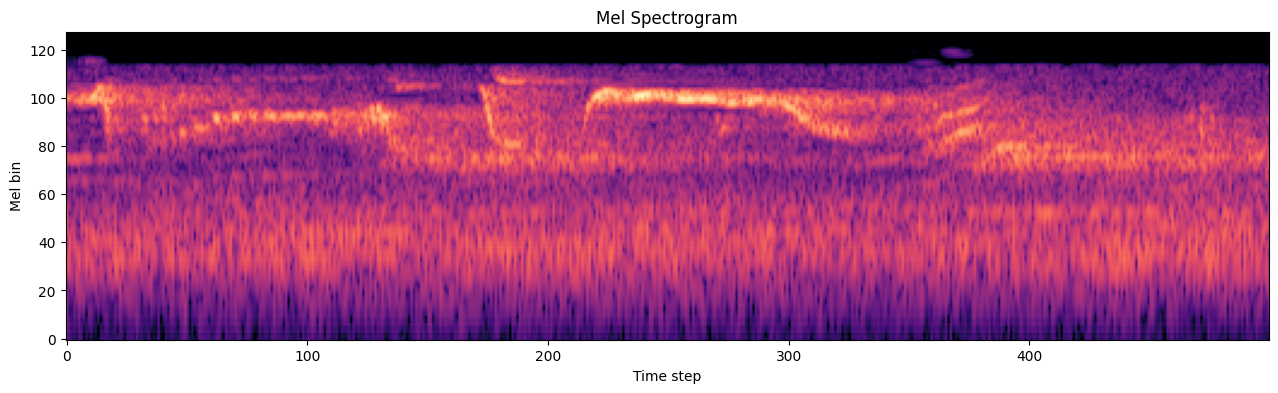

In [81]:
specs, file = test_dataset[0]
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.imshow(specs[0,0], origin='lower', cmap='magma')
plt.grid(visible=False)
plt.title('Mel Spectrogram')
plt.xlabel('Time step')
plt.ylabel('Mel bin')
plt.show()

In [91]:
if Config.use_openvino:
    start=time.time()
    
    checkpoint_ov = Config.checkpoint_dir + '/checkpoint.xml'
    config = {hints.performance_mode: hints.PerformanceMode.THROUGHPUT}
    core = ov.Core()
    model = core.compile_model(checkpoint_ov, "AUTO", config)

    #Peaks
    peaks_weights = np.array([1/Config.n_peaks*k for k in range(Config.n_peaks,0,-1)])[None,:,None]
    n_peaks = Config.n_peaks if Config.use_peaks else 1

    ids = []
    preds = np.empty(shape=(0, n_classes), dtype='float32')
    output_layer = model.output(0)
    if Config.loss == 'crossentropy':
        final_activation = partial(scipy.special.softmax, axis=1)
    elif Config.loss == 'bce':
        final_activation = scipy.special.expit

    test_iter = tqdm(range(len(test_dataset)))
    for i in test_iter:
        #start_sample_time = time.time()
        specs, file = test_dataset[i]
        filename = file.split('/')[-1][:-4]
        #data_time = time.time()
        #print("data", data_time-start_sample_time)
        
        outs = model([specs])[output_layer]
        outs = final_activation(outs)
        #model_time = time.time()
        #print("model", model_time-data_time)
        
        frame_ids = [f'{filename}_{(frame_id+1)*5}' for frame_id in range(len(specs)//n_peaks)]
        ids += frame_ids
        
        if Config.use_peaks:
            outs = outs.reshape((len(specs)//n_peaks, n_peaks, -1))
            outs = scipy.special.softmax(outs @ outs.transpose(0,-1,-2) / (np.sqrt(outs.shape[-1])), axis=-1) @ outs
            outs = outs.mean(1)
            #outs = (outs*peaks_weights).sum(1)/np.sum(peaks_weights)
        preds = np.concatenate([preds, outs], axis=0)
        #end_time = time.time()
        #print("end", end_time-model_time)

    print(time.time()-start)

100%|██████████| 2437/2437 [19:09<00:00,  2.12it/s] 

1149.6089956760406


In [89]:
outs.shape

(5, 3, 182)

In [90]:
outs.transpose((0,-1,-2)).shape

(5, 182, 3)

In [55]:
preds.shape

(11981, 182)

In [56]:
len(ids)

11981

In [92]:
pred_df = pd.DataFrame(ids, columns=['row_id'])
pred_df.loc[:, class_names] = preds

def get_target(row_id):
    name = row_id.split('_')[0]
    target = valid_df.loc[valid_df['filepath'].map(lambda x: x.split('/')[-1][:-4]) == name, 'target'].values[0]
    return target

pred_df['target'] = pred_df.row_id.map(get_target)
submission = pred_df[class_names]

solution = pd.DataFrame()
for class_name in class_names:
    # Create a new column where the value is 1 if the label matches the class index, and 0 otherwise
    solution[class_name] = (pred_df['target'] == name2label[class_name]).astype(int)
    
score(solution, submission, 'row_id')

/tmp/ipykernel_36052/1397243587.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred_df['target'] = pred_df.row_id.map(get_target)
/tmp/ipykernel_36052/1397243587.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  solution[class_name] = (pred_df['target'] == name2label[class_name]).astype(int)
/tmp/ipykernel_36052/1397243587.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

0.9810222752871324

In [35]:
0.9817549533566863, 0.9754093947770046, 0.9762533347855227

0.9754093947770046

In [15]:
device = torch.device('cuda')

model = BasicClassifier(n_classes, pretrained=False, model_name=Config.model_name).to(device)
checkpoint_name = Config.checkpoint
checkpoint = torch.load(checkpoint_name, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model = torch.jit.optimize_for_inference(torch.jit.script(model.eval()))

In [16]:
ids = []
preds = np.empty(shape=(0, n_classes), dtype='float32')

test_iter = tqdm(range(len(test_dataset)))
for i in test_iter:
    specs, file = test_dataset[i]
    filename = file.split('/')[-1][:-4]
    specs = specs.to(device)
    
    with torch.no_grad():
        outs = model(specs)
        if Config.loss == 'crossentropy':
            outs = nn.functional.softmax(outs, dim=1).detach().cpu().numpy()
        elif Config.loss == 'bce':
            outs = outs.sigmoid().detach().cpu().numpy()

    frame_ids = [f'{filename}_{(frame_id+1)*5}' for frame_id in range(len(specs))]
    ids += frame_ids

    preds = np.concatenate([preds, outs], axis=0)

100%|██████████| 4892/4892 [07:37<00:00, 10.70it/s] 


In [17]:
pred_df = pd.DataFrame(ids, columns=['row_id'])
pred_df.loc[:, class_names] = preds

def get_target(row_id):
    name = row_id.split('_')[0]
    target = valid_df.loc[valid_df['filepath'].map(lambda x: x.split('/')[-1][:-4]) == name, 'target'].values[0]
    return target

pred_df['target'] = pred_df.row_id.map(get_target)
submission = pred_df[class_names]

solution = pd.DataFrame()
for class_name in class_names:
    # Create a new column where the value is 1 if the label matches the class index, and 0 otherwise
    solution[class_name] = (pred_df['target'] == name2label[class_name]).astype(int)

/tmp/ipykernel_1191828/1020914727.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred_df['target'] = pred_df.row_id.map(get_target)
/tmp/ipykernel_1191828/1020914727.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  solution[class_name] = (pred_df['target'] == name2label[class_name]).astype(int)
/tmp/ipykernel_1191828/1020914727.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [18]:
score(solution, submission, 'row_id')

0.6495929556132565

In [ ]:
0.6599837509627534